In [1]:
import os, re, json, html
import numpy as np
import random as ra
from tqdm import tqdm
# from src.bpe import GreedyBPE
from src.bpe import HRBPE
from bs4 import BeautifulSoup

def read_training_data(train_sets, data_dir, language, seed, n):
    train_handle = '-'.join(train_sets)
    gold = [ts for train_set in train_sets for ts in json.load(open(f"{data_dir}/{language}/{train_set}.json")).values()]
    if n > 0 and n < len(gold):
        ra.seed(seed)
        gold = ra.sample(gold, n)
    elif n == -1 or n >= len(gold):
        pass
    else:
        raise ValueError
    return ["".join(ts) for ts in gold], train_handle, gold

def get_spans(tokens):
        locs = [0] + list(np.cumsum([len(t) for t in tokens]))
        return  list(zip(locs[0:-1],locs[1:]))

def eval_segmentation(ts, ts_hat):
    y = set(get_spans(ts)); y_hat = set(get_spans(ts_hat))
    TP = len(y_hat.intersection(y)); FP = len(y_hat - y); FN = len(y - y_hat)
    P = TP/(TP+FP) if (TP+FP) else 0
    R = TP/(TP+FN) if (TP+FN) else 0
    F1 = 2*P*R/(P+R) if (P+R) else 0
    return P, R, F1

seed = 691; ra.seed(seed)
method = 'hr-bpe'
init_method = 'char' 
# init_method = 'warm'
num_batches = 100
batch_size = 10_000
actions_per_batch = int(batch_size/1)
reg_model = 'mixing'
# param_method = 'est_type'
# param_method = 'est_doc'
param_method = 'est_theta'
# param_method = 'regress'
# param_method = 'regress_theta'
early_stop = True
language = "EN"
data_dir = "./data/gold"
nsamp = 6000

# load the supplementary data
threaddir = '/home/jake/courses/DSCIT780/data/threads/'
tids = [fname[:-5] for fname in os.listdir(threaddir) if re.search('^\w+\.json$', fname)]
ntids = 10000
ntids = min(len(tids), ntids) # number of threads to sample
thread_handle = f'reddit-privacy-threads-{ntids}'
# model_str = f'{method}_{init_method}_{num_batches}_{batch_size}_{actions_per_batch}_{reg_model}_{param_method}_{language}_{seed}_{train_handle}-{nsamp}'
sample_tids = ra.sample(tids, ntids)
thread_docs = [BeautifulSoup(html.unescape(d.get('body', 
                                          (d.get('title', '') + '\n' + d.get('selftext', ''))).strip('\n')), 
                             "lxml").text for tid in sample_tids for d in json.load(open(threaddir+tid+'.json'))]
# load the training data
train_sets = ["ewtb", "lowlands", "ritter", "parseme-train"]
train_docs, train_handle, train_gold = read_training_data(train_sets, data_dir, language, seed, nsamp)
covering_vocab = set([t for ts in train_gold for t in ts])
covering = list(train_gold) 
# name the model
model_str = f'{method}_{init_method}_{num_batches}_{batch_size}_{actions_per_batch}_{reg_model}_{param_method}_{language}_{seed}_{train_handle}-{nsamp}_{thread_handle}'
docs = train_docs + thread_docs
# check to see what we got
print('model name: ', model_str, '\n')
print('number of samples, total characters, covering size: ', len(docs), sum([len(d) for d in docs]), len(covering_vocab))

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:398: UserWarning: "http://www.deletefacebook.com" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:398: UserWarning: "https://wiki.mumble.info/wiki/Running_Murmur" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:398: UserWarning: "https://libreboot.org/faq.html#hddssd-firmware" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:312: UserW

model name:  hr-bpe_char_100_10000_10000_mixing_est_theta_EN_691_ewtb-lowlands-ritter-parseme-train-6000_reddit-privacy-threads-10000 

number of samples, total characters, covering size:  99166 22005372 11842


/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:398: UserWarning: "https://www.youtube.com/watch?v=ozIKwGt38LQ" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup


In [2]:
covering[1]

['Please',
 ' ',
 'visit',
 ' ',
 'my',
 ' ',
 'website',
 ' ',
 'to',
 ' ',
 'learn',
 ' ',
 'more',
 ' ',
 'about',
 ' ',
 'my',
 ' ',
 'practice',
 ' ',
 'at',
 ' ',
 'www.veraakulov.com',
 '.']

In [3]:
token_index = {"<eos>": 0, "<unk>": 1}
model = HRBPE(param_method=param_method, reg_model=reg_model, early_stop=early_stop, 
              tok2ind = token_index) # , covering_vocab = covering_vocab
model.init(docs, seed=seed, method=init_method, covering = covering,
           action_protect = ["\n","[*\(\{\[\)\}\]\.\?\!\,\;][ ]*\w", "\w[ ]*[*\(\{\[\)\}\]\.\?\!\,\;]"])
model.fit(num_batches, batch_size, actions_per_batch=actions_per_batch, seed=seed)

model.tokenize('this is a test to see how tokenization works on an arbitrary sentence')

Fitting:  13%|███████████████▉                                                                                                           | 13/100 [07:28<49:58, 34.46s/it]


Built a vocabulary of 56300 types


('this',
 ' ',
 'is',
 ' ',
 'a',
 ' ',
 't',
 'e',
 'st',
 ' ',
 'to',
 ' ',
 's',
 'e',
 'e',
 ' ',
 'how',
 ' ',
 'token',
 'ization',
 ' ',
 'works',
 ' ',
 'on',
 ' ',
 'a',
 'n',
 ' ',
 'arbitrary',
 ' ',
 's',
 'e',
 'n',
 't',
 'e',
 'nce')

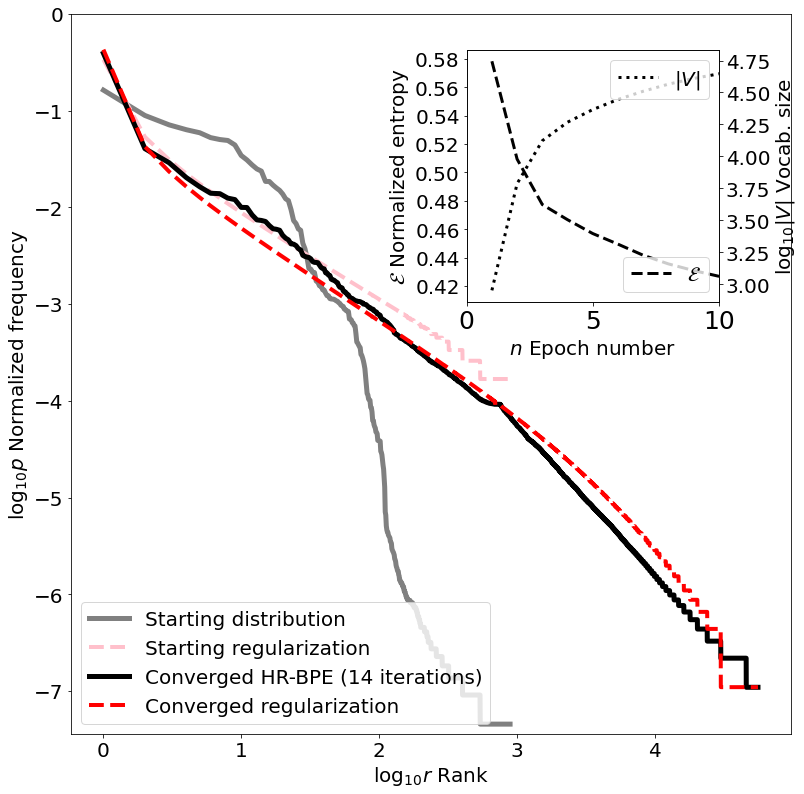

In [4]:
model.display_epochs(fname = 'img/' + model_str + '.png')

Results by the `'regress_theta'` method, which merges the covering and covered tokens of a vocabulary:
```
with 1 thread:
- P, R, F1: [0.5439240588877221, 0.7853464480450258, 0.6351837302274742]
with 10 threads:
- P, R, F1: [0.5473520696069848, 0.7878414794975205, 0.6382979653996623]
with 100 threads:
- P, R, F1: [0.5590421705222007, 0.794544866772627, 0.648861981193056]
with 1000 threads:
- P, R, F1: [0.6150348779580214, 0.828224440535471, 0.6977321039142568]
with 10000 threads:
- P, R, F1: [0.6332812612278924, 0.8365140770050181, 0.712705025346611]
```

Results by the `'regress_theta'` method, with merges coforming under a positional covering (gold tokenization):
```
with 1 thread:
- P, R, F1: [0.5508993408194046, 0.7963483709277502, 0.6432619091776358]
with 10 threads:
- P, R, F1: [0.5265977934771198, 0.7787350859313389, 0.62051201301476]
with 100 threads:
- P, R, F1: [0.5703482529506562, 0.8063852262338111, 0.6598749556157072]
with 1000 threads:
- P, R, F1: [0.5860991713323762, 0.8159955107070732, 0.6739022523072684]
with 10000 threads:
- P, R, F1: [0.6065336714999103, 0.8262617805965031, 0.6907931087621503]
```

In [5]:
test_sets = ["parseme-test", "ted", "trustpilot", "tweebank"]
test_docs, test_handle, test_gold = read_training_data(test_sets, data_dir, language, seed, nsamp)

print("P, R, F1: ", list(map(np.mean, zip(*[eval_segmentation(ts, model.tokenize("".join(ts))) for ts in tqdm(test_gold) if ts]))))
[model.tokenize("".join(ts)) for ts in test_gold[1:2] if ts]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1011/1011 [05:03<00:00,  3.33it/s]


P, R, F1:  [0.6065336714999103, 0.8262617805965031, 0.6907931087621503]


[('Sh',
  'uck',
  's',
  ',',
  ' ',
  'guess',
  ' ',
  'n',
  'on',
  'e',
  ' ',
  'of',
  ' ',
  'us',
  ' ',
  'three',
  ' ',
  'paid',
  ' ',
  'much',
  ' ',
  'attention',
  ' ',
  'to',
  ' ',
  'that',
  '.')]

In [6]:
model.save('cache/' + model_str + '.json')

In [7]:
# ntids = 10000
# ntids = min(len(tids), ntids) # number of threads to sample
# thread_handle = f'reddit-privacy-threads-{ntids}'
# model_str = f'{method}_{init_method}_{num_batches}_{batch_size}_{actions_per_batch}_{reg_model}_{param_method}_{language}_{seed}_{train_handle}-{nsamp}_{thread_handle}'

# mod = HRBPE(param_method=param_method, reg_model=reg_model, early_stop=early_stop)
# mod.load('cache/' + model_str + '.json')
# mod.init([], seed=seed, method=init_method)
# print("P, R, F1: ", list(map(np.mean, zip(*[eval_segmentation(ts, mod.tokenize("".join(ts))) for ts in tqdm(test_gold) if ts]))))
# [mod.tokenize("".join(ts)) for ts in test_gold[1:2] if ts]